In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy.api as sc

import scipy
scipy.__version__

'1.2.2'

In [2]:
#designate working directory 
#path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
#for scanpy annotations: barcodes.tsv, genes.tsv
#
#



path='/Users/derekbogdanoff/projects/XYZeq/data/20190319_miSeq/human_mouse_gene_count/'

plate_map='../XYZeq/data/20181219_species_exp/plate23_map.csv'



In [3]:
sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
results_file = './write/results.h5ad'

#sc.settings = True

##load the data
adata=sc.read(path + 'matrix.mtx', cache=True).T


##name the genes
adata.var_names = [gene.strip() for gene in open(path + 'genes2.tsv', 'r')]


##name the cells
adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.17.2 scipy==1.2.2 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata.var_names_make_unique()

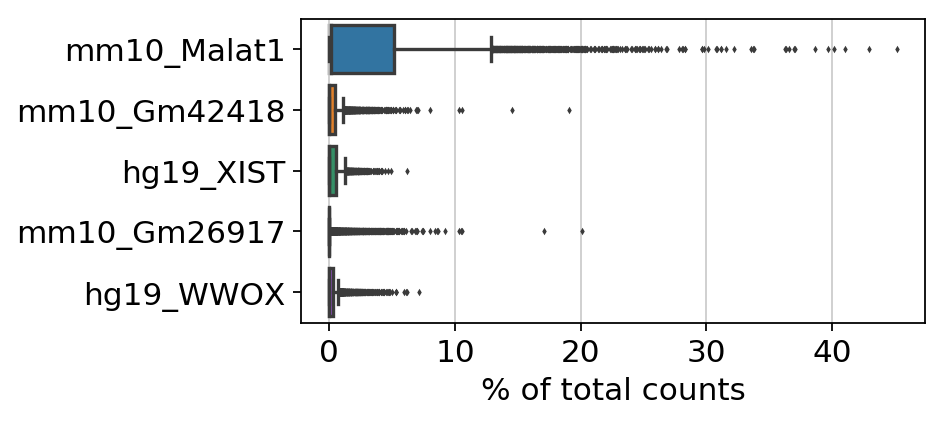

In [5]:
sc.pl.highest_expr_genes(adata, n_top=5) 

In [7]:
adata

AnnData object with n_obs × n_vars = 8276 × 121472 

In [8]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, min_genes=100)

#sc.pp.filter_cells(adata, max_counts=15000)
#sc.pp.filter_cells(adata, max_genes=2000) 

##post processing filter genes 
sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)



filtered out 1365 cells that have less than 200 counts
filtered out 392 cells that have less than 100 genes expressed
filtered out 89764 genes that are detected in less than 2 cells


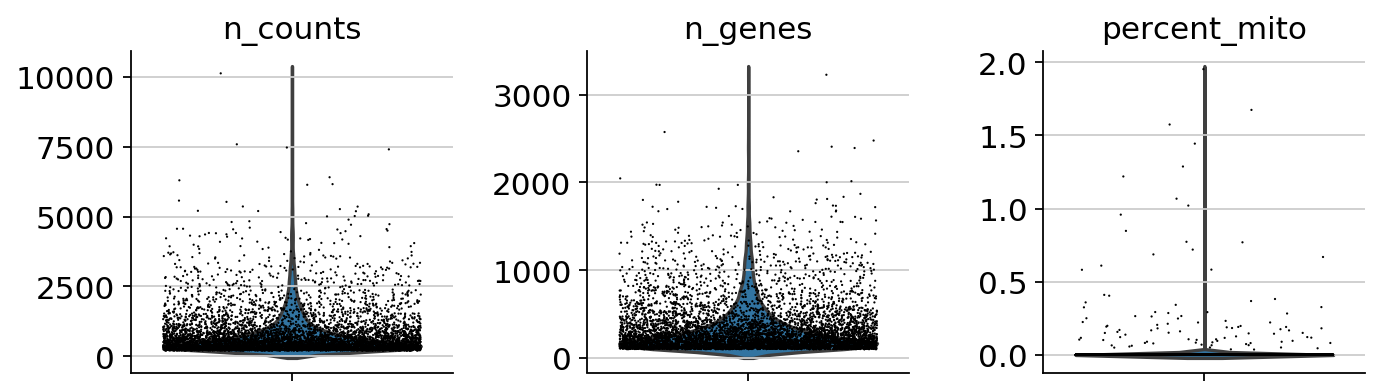

In [9]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)

In [10]:
##filter out outliers

adata = adata[adata.obs['n_genes'] < 15000, :]
adata = adata[adata.obs['n_counts'] < 10000, :]
adata = adata[adata.obs['percent_mito'] < 1, :]


/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  Fu

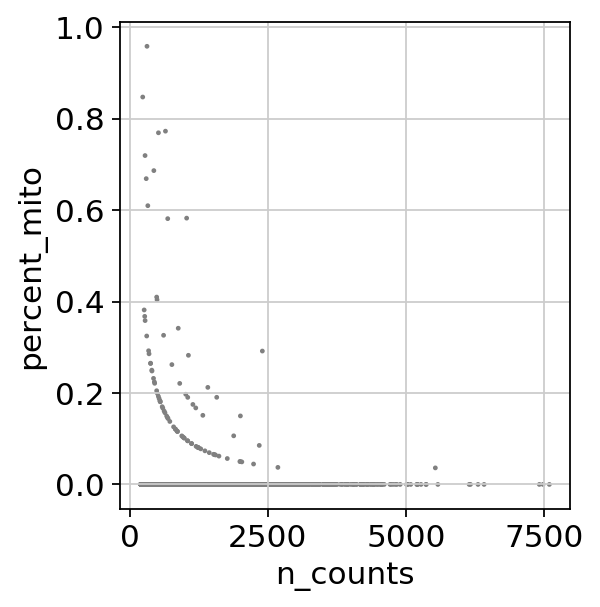

/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  Fu

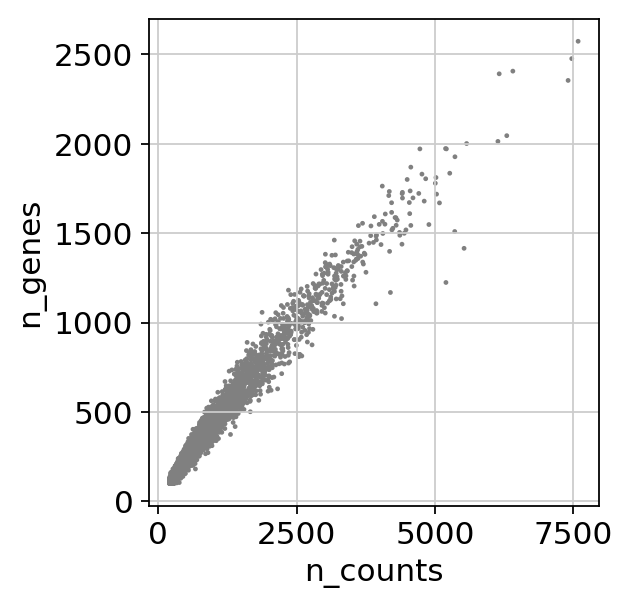

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



In [12]:
adata

AnnData object with n_obs × n_vars = 6510 × 31708 
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

In [13]:
#barnyard


mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
human_genes=[name for name in adata.var_names if name.startswith('hg19_')]



adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)



In [14]:
# # fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])


In [15]:
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))


def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

            
            
            
adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)




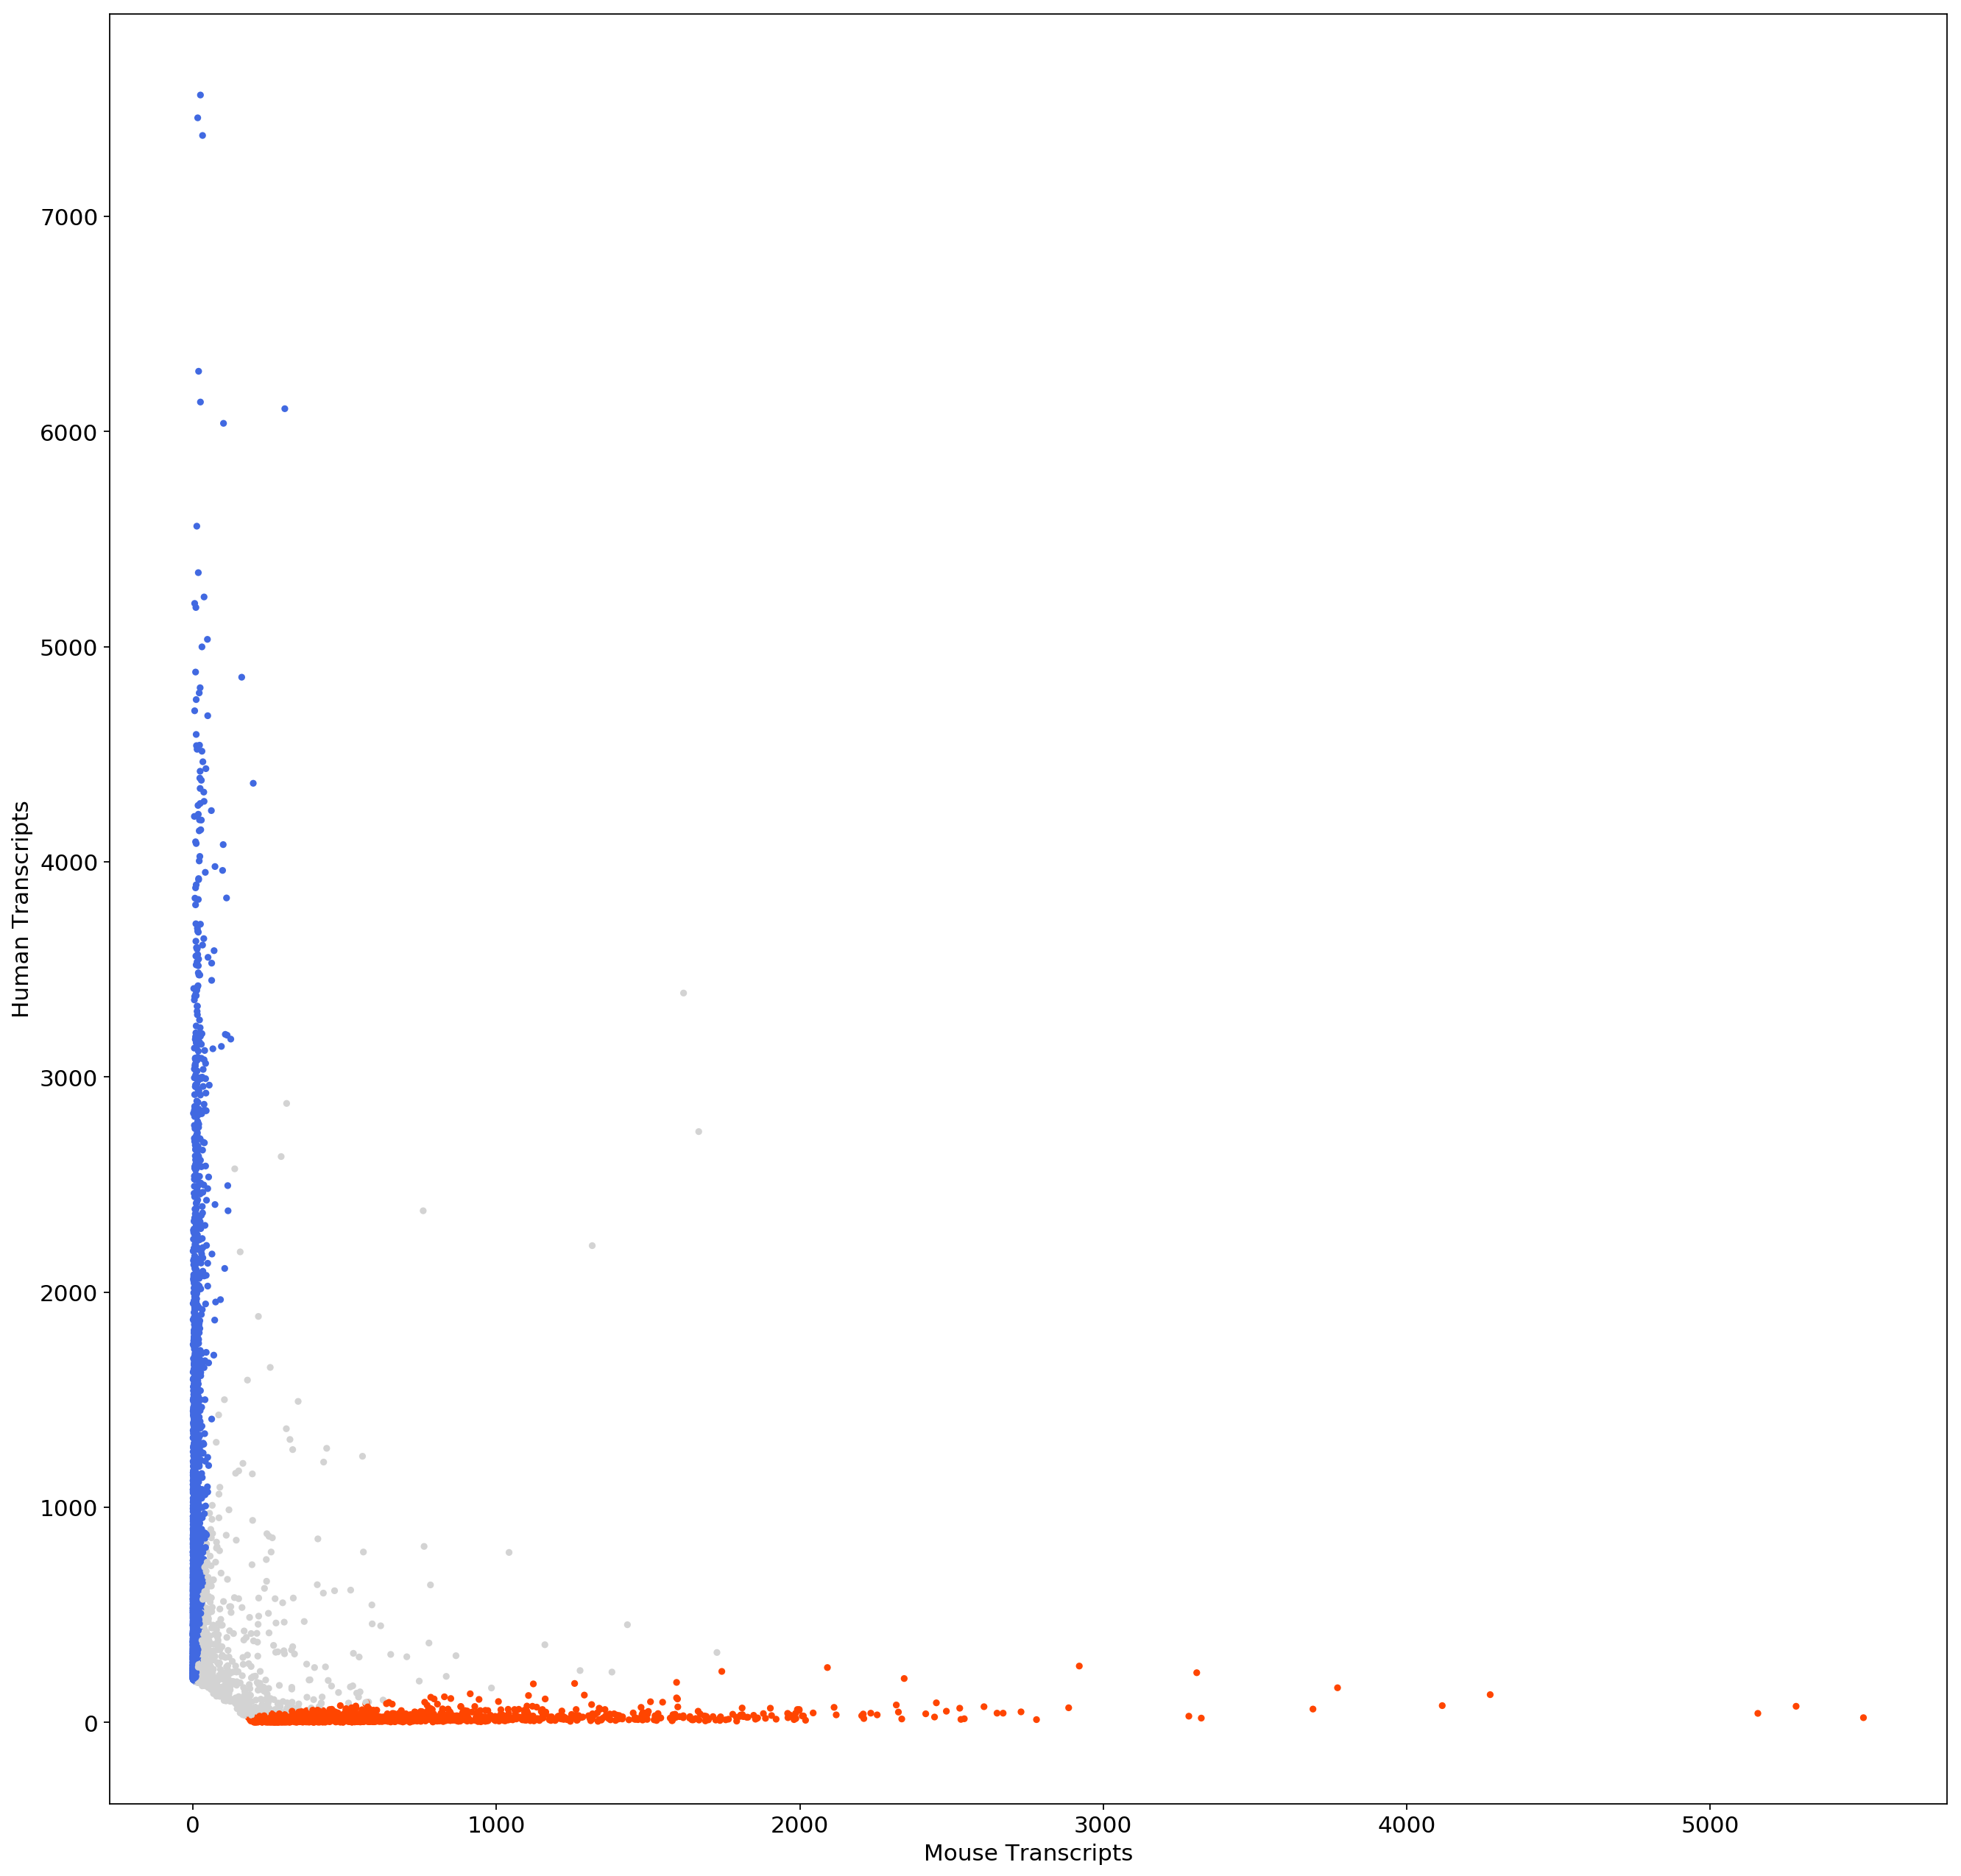

In [16]:
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap)


plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

#plt.savefig('/Users/derekbogdanoff/Desktop/test.svg', bbox_inches='tight')


In [17]:
adata.obs['cell_call'].value_counts()

H    4442
M    1734
C     334
Name: cell_call, dtype: int64

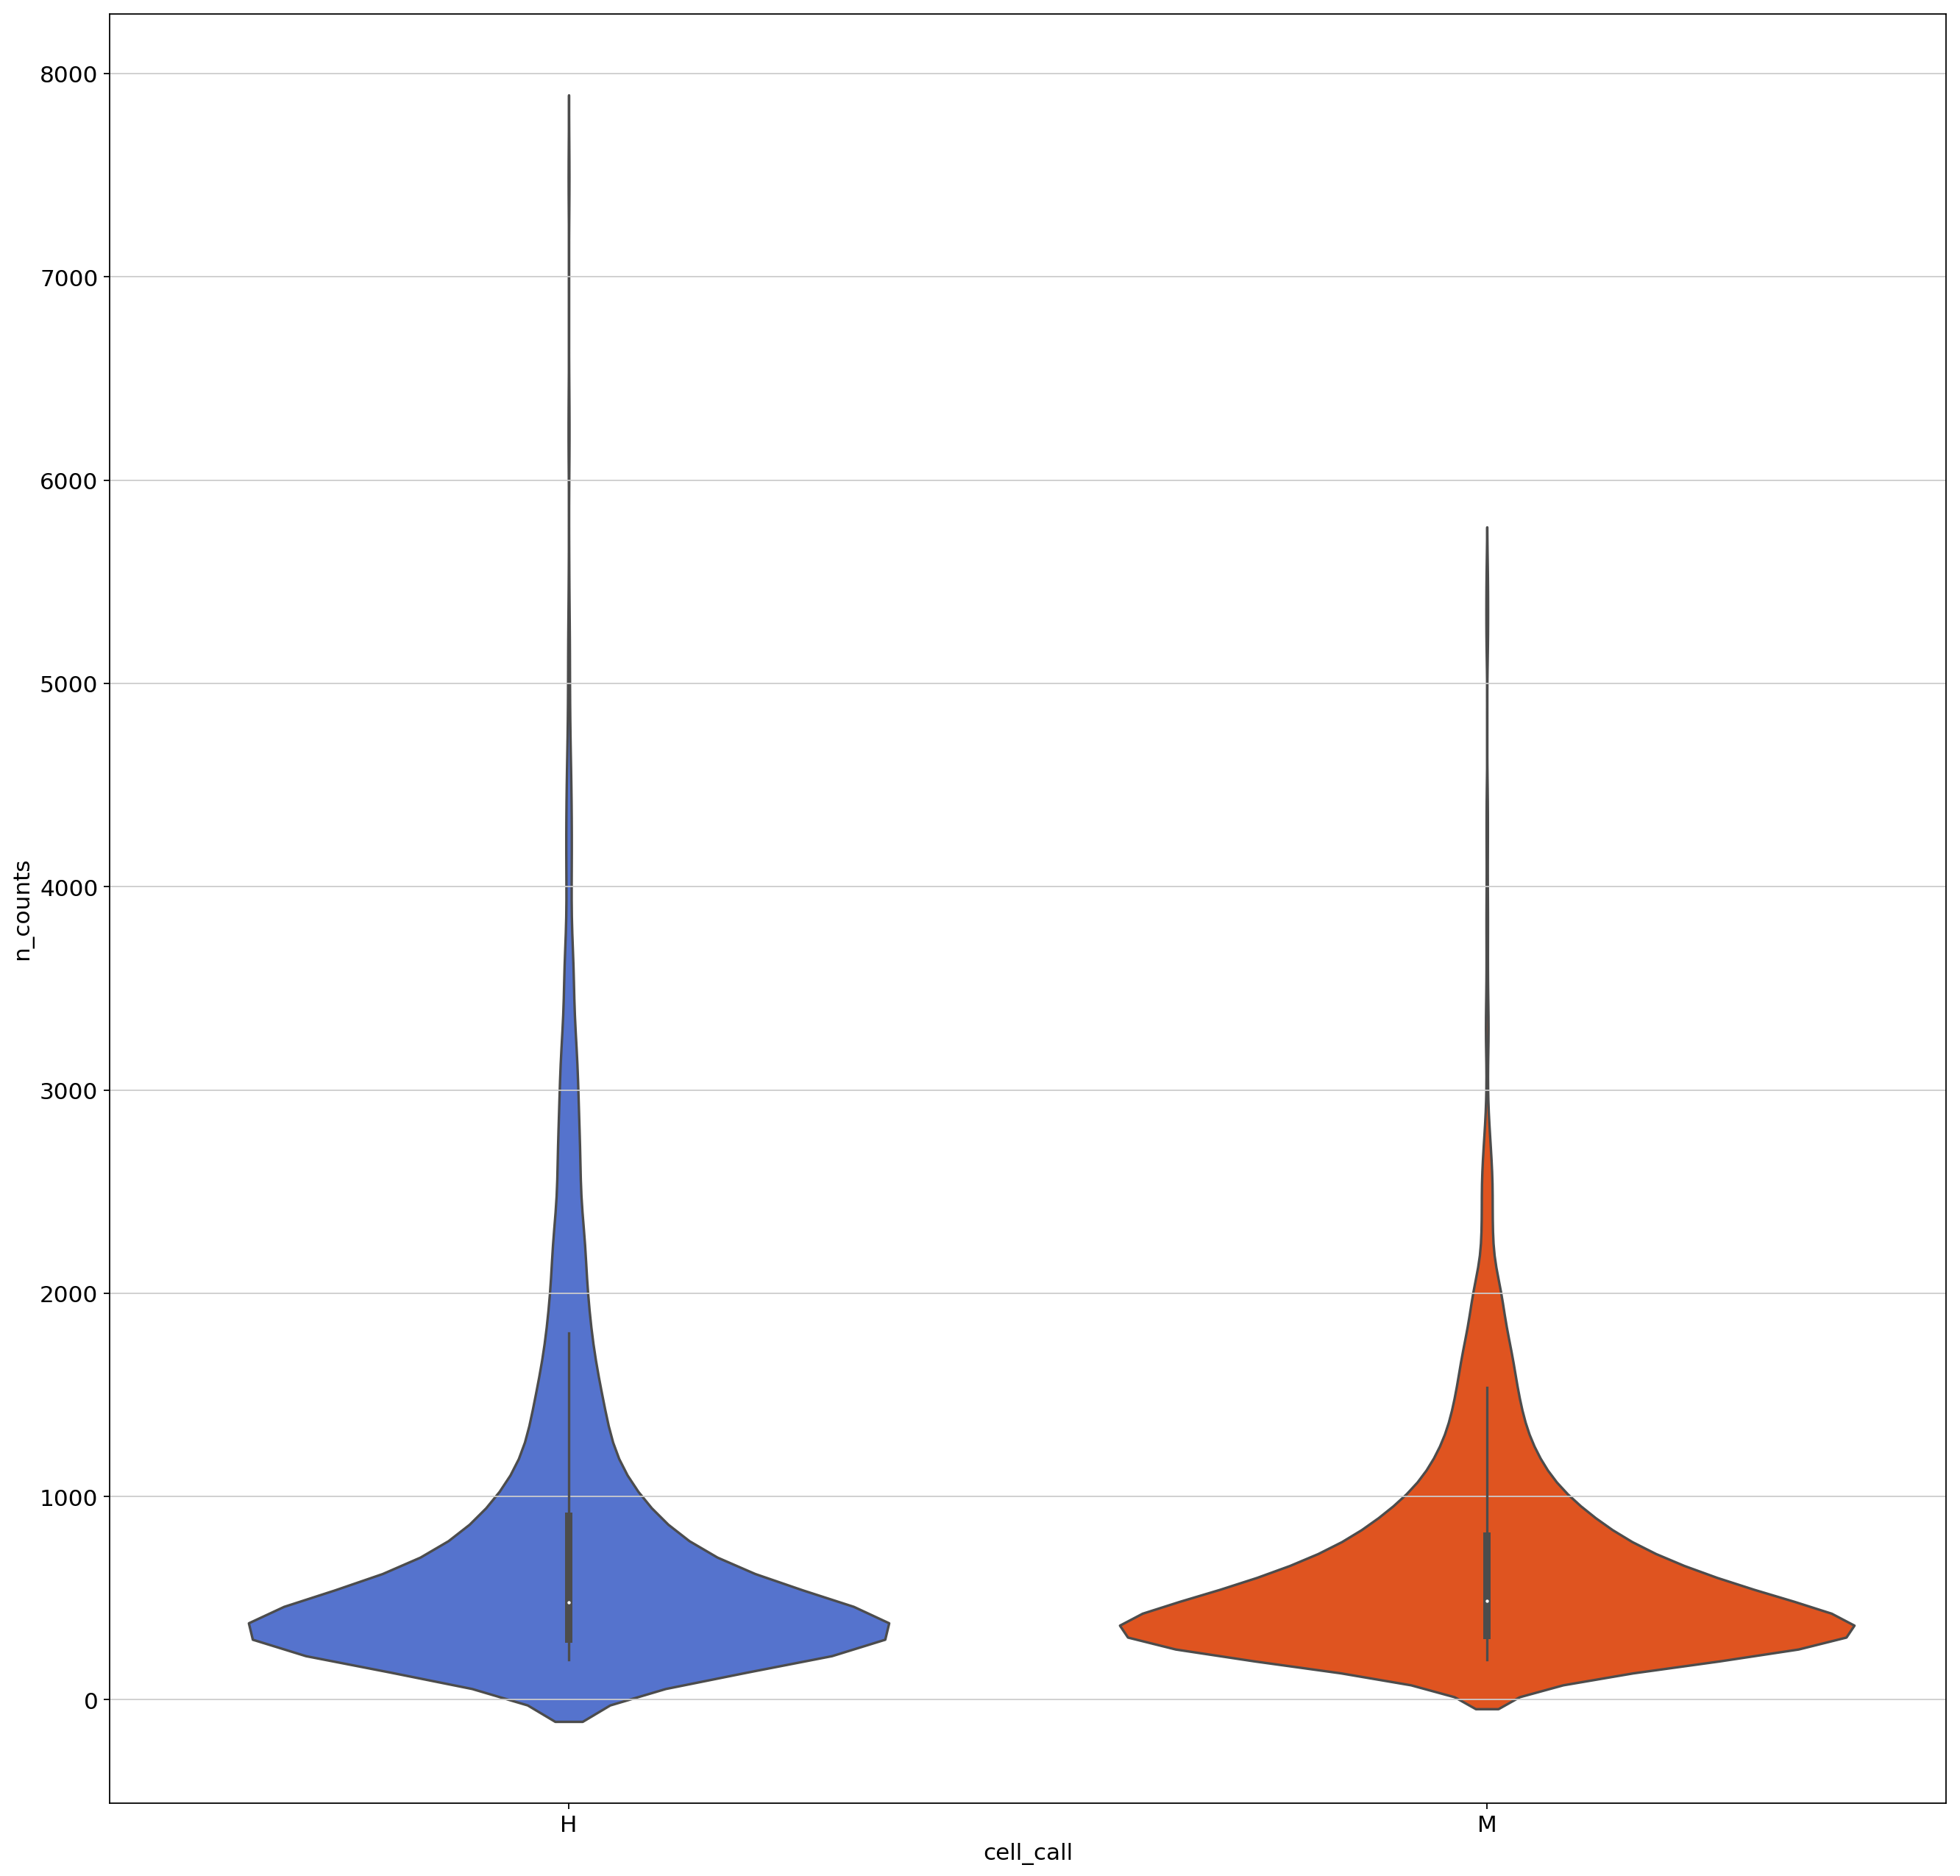

In [18]:
sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered']
              )

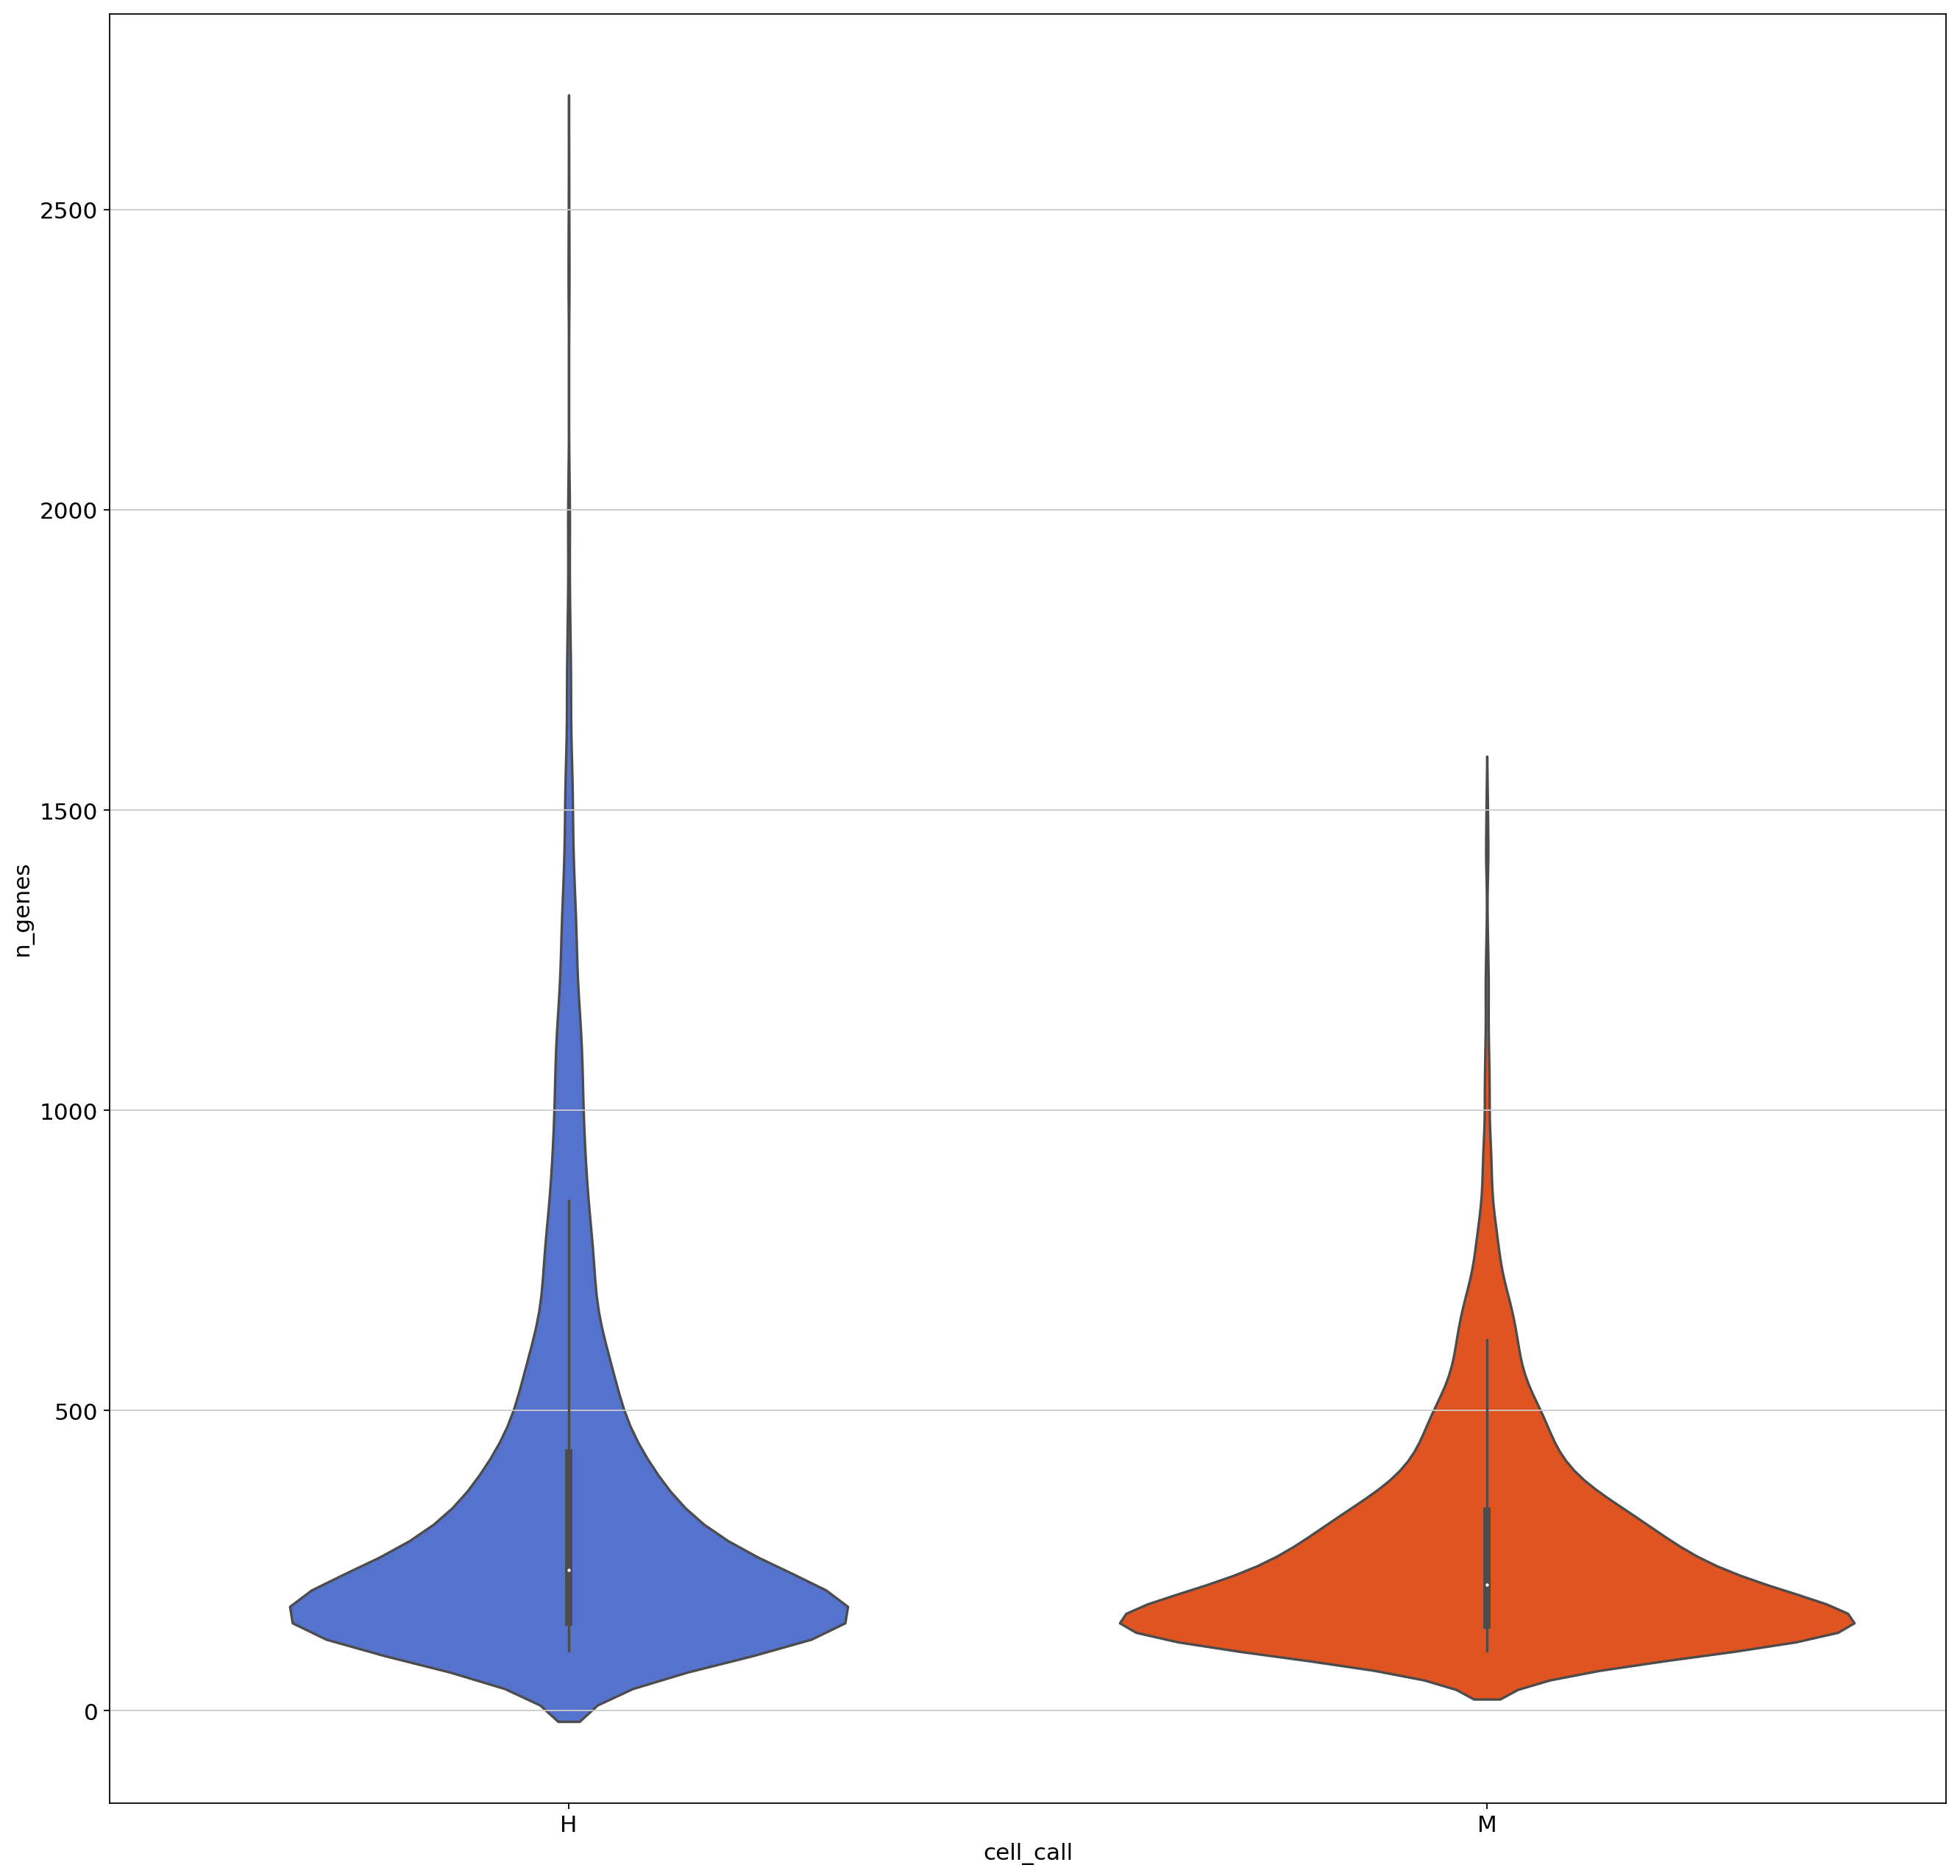

In [19]:
sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_genes',
               palette=['royalblue', 'orangered']
              )

In [20]:
np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)

210.0

In [21]:
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])





In [22]:
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [88]:
df=pd.DataFrame(adata.obs.cell_call)

df['barcode']=df.index.str[-16:]

df.cell_call['cell_call']=df.cell_call.astype('category')

df=df.merge(spatial_map,on='barcode',how='right')

df=df.dropna()

In [89]:
list_=[]

for index, row in df.iterrows():
    if row['X'] % 2 != 0:
        row['Y']=row['Y']-0.5
    else:  
        row['Y']=row['Y']
        
    list_.append(row['Y'])
        

In [90]:
df['Y']=list_

In [91]:
df['Y']=df['Y']/2

In [92]:
color_dict={'H':'royalblue', 
            'M':'orangered',
            'C':'lightgrey',
           }

In [93]:
df['color']=df['cell_call'].map(color_dict)

In [94]:
df_bar=df.groupby('X')['cell_call'].value_counts(['']).unstack()

In [95]:
df_bar.columns.name='Cell Species'

In [96]:
df_bar=df_bar[['M','H','C']]

In [97]:
barplot_cmap=mpl.colors.ListedColormap(['red','royalblue','lightgrey'])

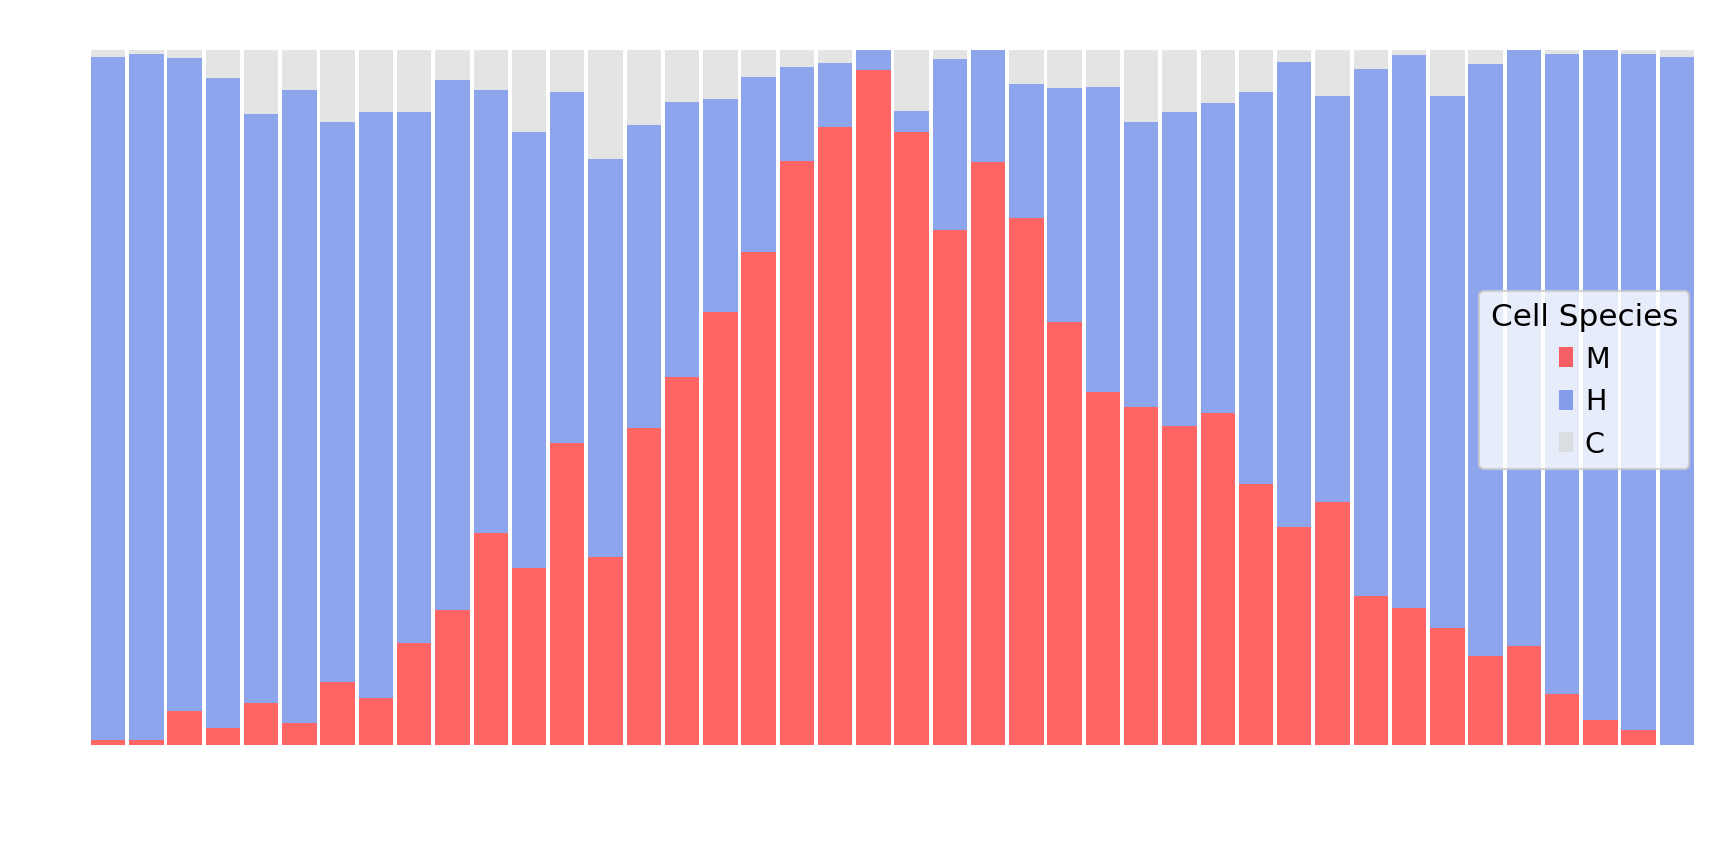

In [98]:
plt.rcParams['figure.figsize'] = [13, 6]

df_bar.plot.bar(stacked=True,
                width=0.9, 
                cmap=barplot_cmap, 
                ecolor='white',
               alpha=.6)


plt.axis('off')
plt.grid(False)             

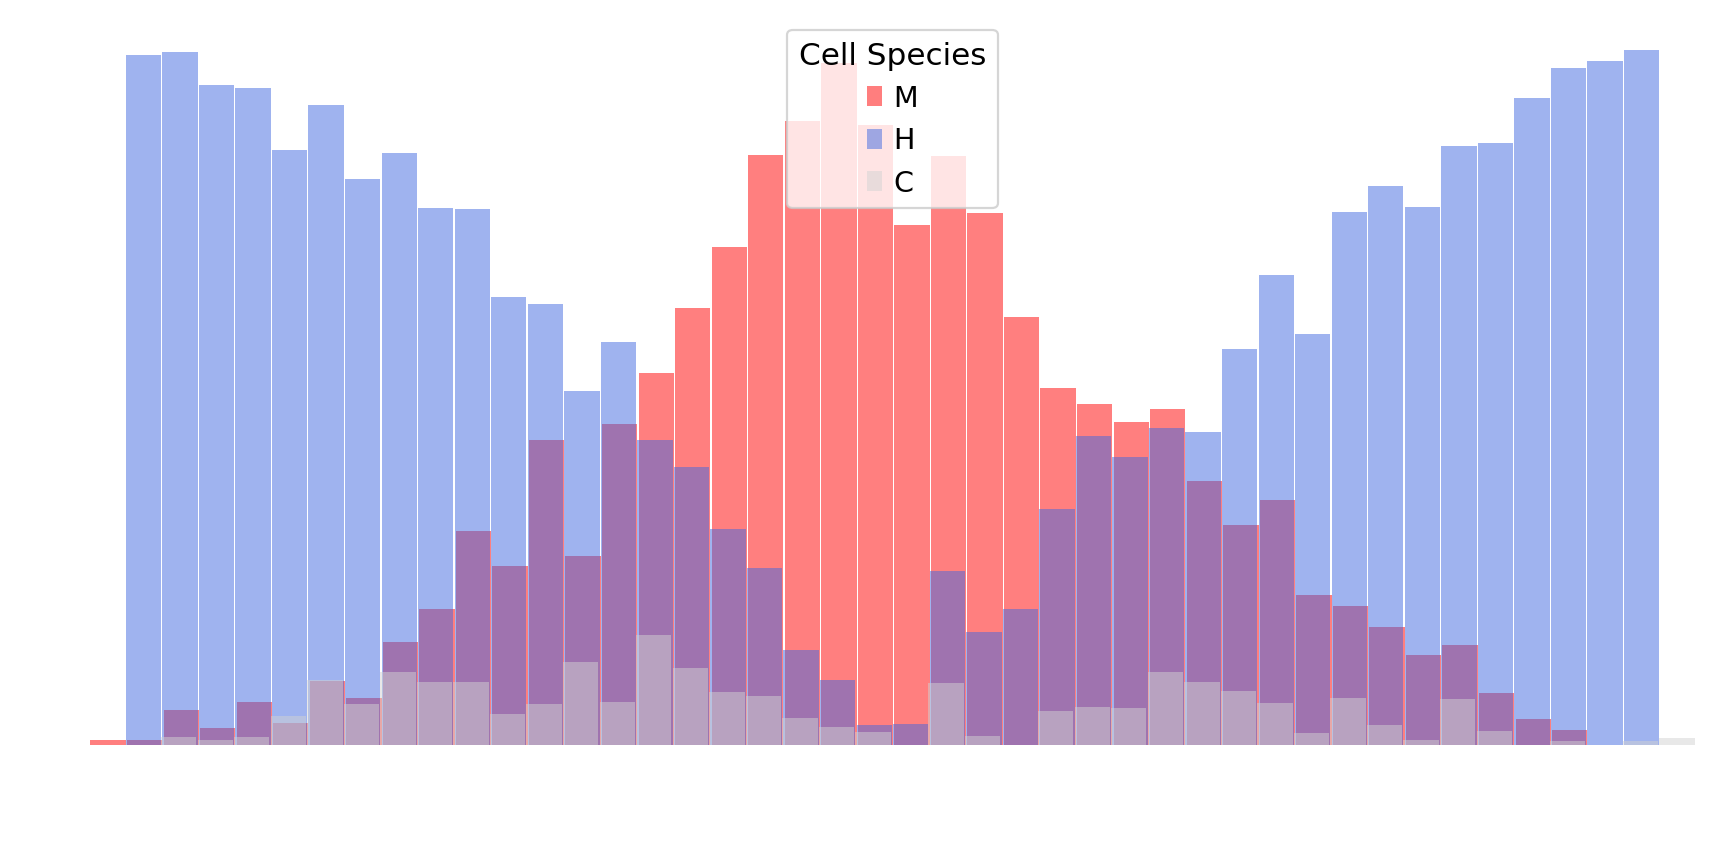

In [99]:
plt.rcParams['figure.figsize'] = [13, 6]

df_bar.plot.bar(stacked=False,
                width=2.9, 
                cmap=barplot_cmap, 
                ecolor='white',
                alpha=.5
               )


plt.axis('off')
plt.grid(False)      

In [124]:
df['counts']=adata.obs['n_counts'].reset_index()['n_counts']

In [127]:
df['log counts']=np.log10(df['counts'])

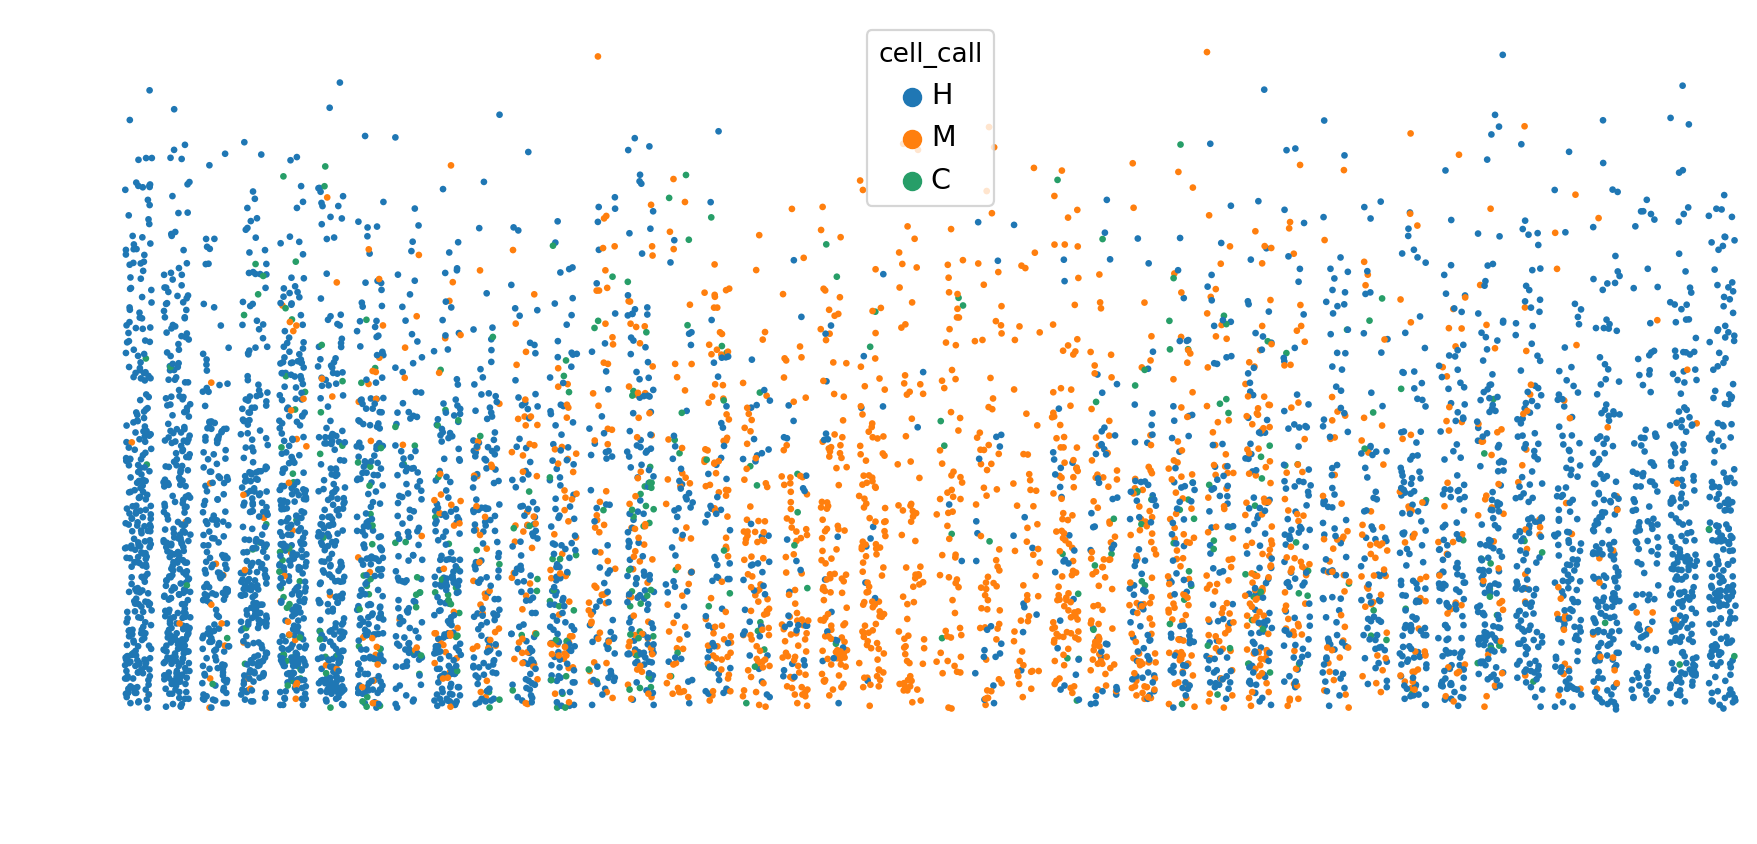

In [129]:
sns.stripplot(x='X', 
              y='log counts', 
              data=df, 
              hue='cell_call',
        
              jitter=0.35,
              size=3)

plt.axis('off')
plt.grid(False) 


In [134]:
df['X']=rand_jitter(df['X'])
df['Y']=rand_jitter(df['Y'])


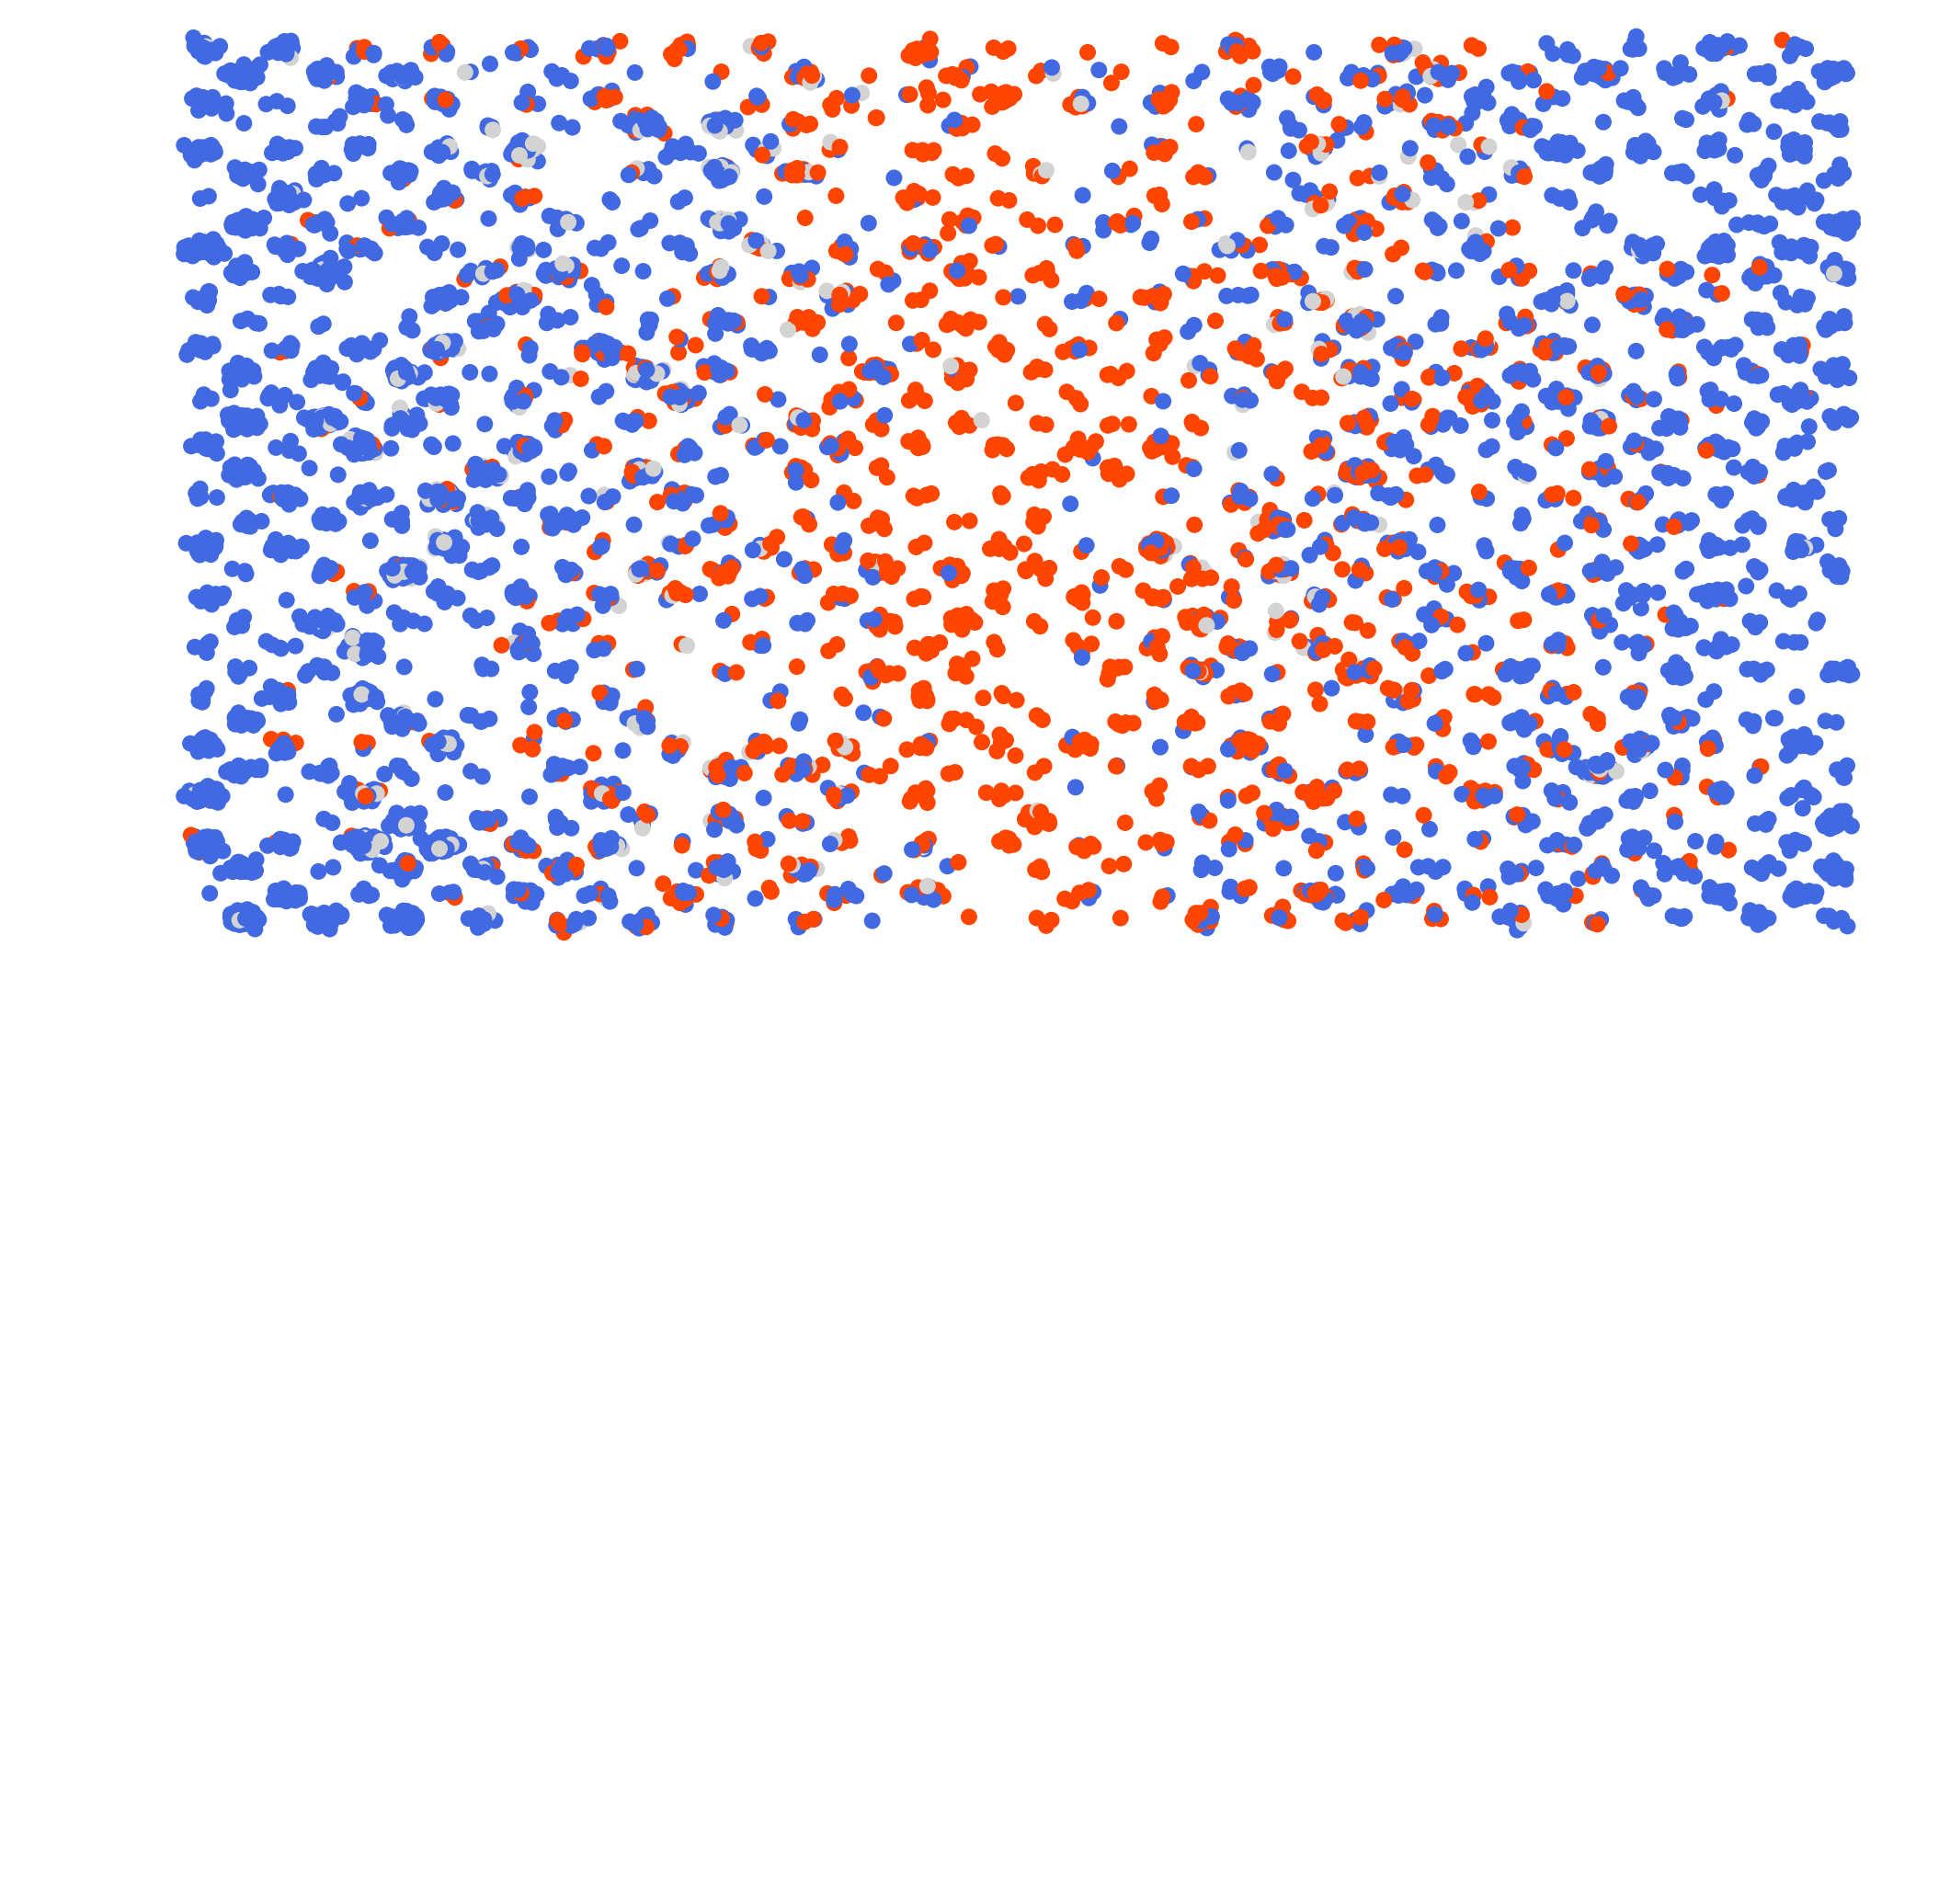

In [138]:
plt.rcParams['figure.figsize'] = [16, 16]

df.plot.scatter(x='X',y='Y',c=df['color'], s=50)
plt.ylim(18,0)

plt.axis('off')
plt.grid(False)